In [94]:
# agrego reloader para no tener que cerrar y abrir vs code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulador de estrategia optima de carrera

### Armado del dataset de carrera para los parametros

In [95]:
import fastf1
import pandas as pd

# 1) Activar caché (ajustá el path a tu proyecto)
fastf1.Cache.enable_cache("cache")

# 2) Parámetros de la sesión
YEAR = 2025
GP_NAME = "Monaco"
SESSION = "R"     # 'R' = Race

session = fastf1.get_session(YEAR, GP_NAME, SESSION)
session.load()

# 3) Laps de Colapinto
laps = session.laps.pick_driver("COL").copy()

# 4) Normalizar algunas columnas para que encajen con tu pipeline
laps["Session"] = "RACE"   # tu FE usa 'Session' con strings
laps = laps.sort_values("LapNumber").reset_index(drop=True)

print(laps[["LapNumber", "LapTime", "Compound", "TyreLife", "Stint", "TrackStatus"]].head())
print("Última vuelta:", laps["LapNumber"].max())
print("Filas:", len(laps))

# 5) Guardar CSV solo de carrera
laps.to_csv("data/processed/monaco_2025_colapinto_race.csv", index=False)


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']


   LapNumber                LapTime Compound  TyreLife  Stint TrackStatus
0        1.0 0 days 00:01:36.577000     HARD       1.0    1.0         126
1        2.0 0 days 00:01:50.894000     HARD       2.0    1.0           6
2        3.0 0 days 00:01:48.913000     HARD       3.0    1.0           6
3        4.0 0 days 00:01:36.476000     HARD       4.0    1.0         671
4        5.0 0 days 00:01:19.999000     HARD       5.0    1.0           1
Última vuelta: 76.0
Filas: 76


c:\Users\Franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


### Entrenamiento del predictor de vuelta
(mismos parametros que el mejor modelo entrenado)

In [96]:
import pandas as pd
from src.preprocessing import add_basic_features
from src.simulator import Strategy, simulate_strategies
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# ============================================================
# 1) Cargar dataset COMPLETO (prácticas + carrera) para entrenar
# ============================================================
df_all = pd.read_csv("data/processed/monaco_2025_colapinto_alllaps.csv")

# Filtrar solo vueltas con pista verde (TrackStatus == 1)
if "TrackStatus" in df_all.columns:
    df_all = df_all[df_all["TrackStatus"] == 1].copy()
    print(f"Vueltas con pista verde: {len(df_all)}")

# Aplicar feature engineering v2
df_fe2 = add_basic_features(df_all)

# Definir features para FE v2 (EXACTAMENTE como en pruebas.ipynb)
LEGAL_FEATURES_NUM_V2 = [
    "LapNumber",
    "Stint",
    "TyreLife",
    "lap_norm_session",
    "is_race",
    "compound_order",
]

LEGAL_FEATURES_CAT_V2 = [
    "Session",
    "Compound",
]

# Filtrar solo las features que existen en el dataframe
LEGAL_FEATURES_NUM_V2 = [c for c in LEGAL_FEATURES_NUM_V2 if c in df_fe2.columns]
LEGAL_FEATURES_CAT_V2 = [c for c in LEGAL_FEATURES_CAT_V2 if c in df_fe2.columns]

print("Features numéricas:", LEGAL_FEATURES_NUM_V2)
print("Features categóricas:", LEGAL_FEATURES_CAT_V2)

# ============================================================
# 2) Entrenar modelo GB FE_v2 (EXACTAMENTE como en pruebas.ipynb)
# ============================================================

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), LEGAL_FEATURES_NUM_V2),
        ("cat", OneHotEncoder(handle_unknown="ignore"), LEGAL_FEATURES_CAT_V2),
    ]
)

# Modelo GB con hiperparámetros EXACTOS de pruebas.ipynb (R2 = 0.751)
gb_fe2 = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Pipeline completo
lap_time_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gb_fe2)
])

X_train = df_fe2[LEGAL_FEATURES_NUM_V2 + LEGAL_FEATURES_CAT_V2]
y_train = df_fe2["LapTime_s"]

lap_time_model.fit(X_train, y_train)

print(f"\nModelo GB FE_v2 entrenado con {len(X_train)} vueltas")
print(f"Distribución por sesión:")
print(df_fe2["Session"].value_counts())
print(f"\n✓ Modelo IDÉNTICO al de pruebas.ipynb (R2 medio = 0.751)")

# ============================================================
# 3) Cargar datos de carrera (76 vueltas que completó Colapinto)
# ============================================================
df_race = pd.read_csv("data/processed/monaco_2025_colapinto_race.csv")
df_race_fe = add_basic_features(df_race)

print(f"\nVueltas completadas por Colapinto: {len(df_race_fe)}")
print(f"Total de vueltas de la carrera: {session.total_laps}")
print(f"Estado: Lapped (perdió {session.total_laps - len(df_race_fe)} vueltas)")


Vueltas con pista verde: 100
Features numéricas: ['LapNumber', 'Stint', 'TyreLife', 'lap_norm_session', 'is_race', 'compound_order']
Features categóricas: ['Session', 'Compound']

Modelo GB FE_v2 entrenado con 100 vueltas
Distribución por sesión:
Session
RACE    65
FP2     14
FP1     12
FP3      9
Name: count, dtype: int64

✓ Modelo IDÉNTICO al de pruebas.ipynb (R2 medio = 0.751)

Vueltas completadas por Colapinto: 76
Total de vueltas de la carrera: 78
Estado: Lapped (perdió 2 vueltas)


### Definir y simular estrategias

In [97]:
# Usar las 76 vueltas que completó Colapinto
total_laps = int(df_race_fe["LapNumber"].max())
print(f"Total de vueltas para simulación: {total_laps}")

# Definir diferentes estrategias a evaluar (para 76 vueltas)
strategies = [
    Strategy("S-M-H", [("SOFT", 15), ("MEDIUM", 22), ("HARD", total_laps - 37)]),
    Strategy("M-M-H", [("MEDIUM", 20), ("MEDIUM", 20), ("HARD", total_laps - 40)]),
    Strategy("M-H", [("MEDIUM", 25), ("HARD", total_laps - 25)]),
    Strategy("H-M", [("HARD", 30), ("MEDIUM", total_laps - 30)]),
    Strategy("H-S", [("HARD", 35), ("SOFT", total_laps - 35)]),
    Strategy("S-H", [("SOFT", 20), ("HARD", total_laps - 20)]),
]

print("\nEstrategias a evaluar:")
for strat in strategies:
    print(f"  {strat.name}: {strat.stints}")


Total de vueltas para simulación: 76

Estrategias a evaluar:
  S-M-H: [('SOFT', 15), ('MEDIUM', 22), ('HARD', 39)]
  M-M-H: [('MEDIUM', 20), ('MEDIUM', 20), ('HARD', 36)]
  M-H: [('MEDIUM', 25), ('HARD', 51)]
  H-M: [('HARD', 30), ('MEDIUM', 46)]
  H-S: [('HARD', 35), ('SOFT', 41)]
  S-H: [('SOFT', 20), ('HARD', 56)]


In [98]:
# Simular todas las estrategias
# NOTA: El modelo ya incluye el preprocessor, así que le pasamos las features originales

standings = simulate_strategies(
    df_race_base=df_race_fe,
    lap_time_model=lap_time_model,
    legal_features_num=LEGAL_FEATURES_NUM_V2,
    legal_features_cat=LEGAL_FEATURES_CAT_V2,
    strategies=strategies,
    pit_loss_s=20.0,  # Penalización de 20 segundos por pit stop
)

print("\n=== Clasificación de Estrategias ===")
standings



=== Clasificación de Estrategias ===


,strategy_name,total_time_s,position,total_time_str
0,H-S,5973.963833,1,99:33.964
1,S-H,5974.524052,2,99:34.524
2,M-H,5986.013163,3,99:46.013
3,H-M,5999.558279,4,99:59.558
4,S-M-H,6012.892581,5,100:12.893
5,M-M-H,6017.714862,6,100:17.715


### Análisis detallado de la mejor estrategia

In [99]:
from src.simulator import simulate_strategy_for_driver

# Obtener la mejor estrategia
best_strategy_name = standings.iloc[0]["strategy_name"]
best_strategy = [s for s in strategies if s.name == best_strategy_name][0]

print(f"Mejor estrategia: {best_strategy_name}")
print(f"Tiempo total: {standings.iloc[0]['total_time_str']}")
print(f"\nDetalle de stints:")
for i, (compound, laps) in enumerate(best_strategy.stints, 1):
    print(f"  Stint {i}: {compound} - {laps} vueltas")

# Simular detalladamente la mejor estrategia
best_result = simulate_strategy_for_driver(
    df_race_base=df_race_fe,
    lap_time_model=lap_time_model,
    legal_features_num=LEGAL_FEATURES_NUM_V2,
    legal_features_cat=LEGAL_FEATURES_CAT_V2,
    strategy=best_strategy,
    pit_loss_s=20.0,
)

# Mostrar las primeras vueltas de cada stint
df_best = best_result["df_sim"]
print("\n=== Tiempos por vuelta (primeras de cada stint) ===")
df_best[df_best["TyreLife"] == 1][["LapNumber", "Stint", "Compound", "LapTime_pred_s", "PitLoss_s", "LapTime_total_s"]]


Mejor estrategia: H-S
Tiempo total: 99:33.964

Detalle de stints:
  Stint 1: HARD - 35 vueltas
  Stint 2: SOFT - 41 vueltas

=== Tiempos por vuelta (primeras de cada stint) ===


,LapNumber,Stint,Compound,LapTime_pred_s,PitLoss_s,LapTime_total_s
0,1.0,1,HARD,82.031055,15.0,97.031055
35,36.0,2,SOFT,79.102847,20.0,99.102847


### Visualización de tiempos por vuelta

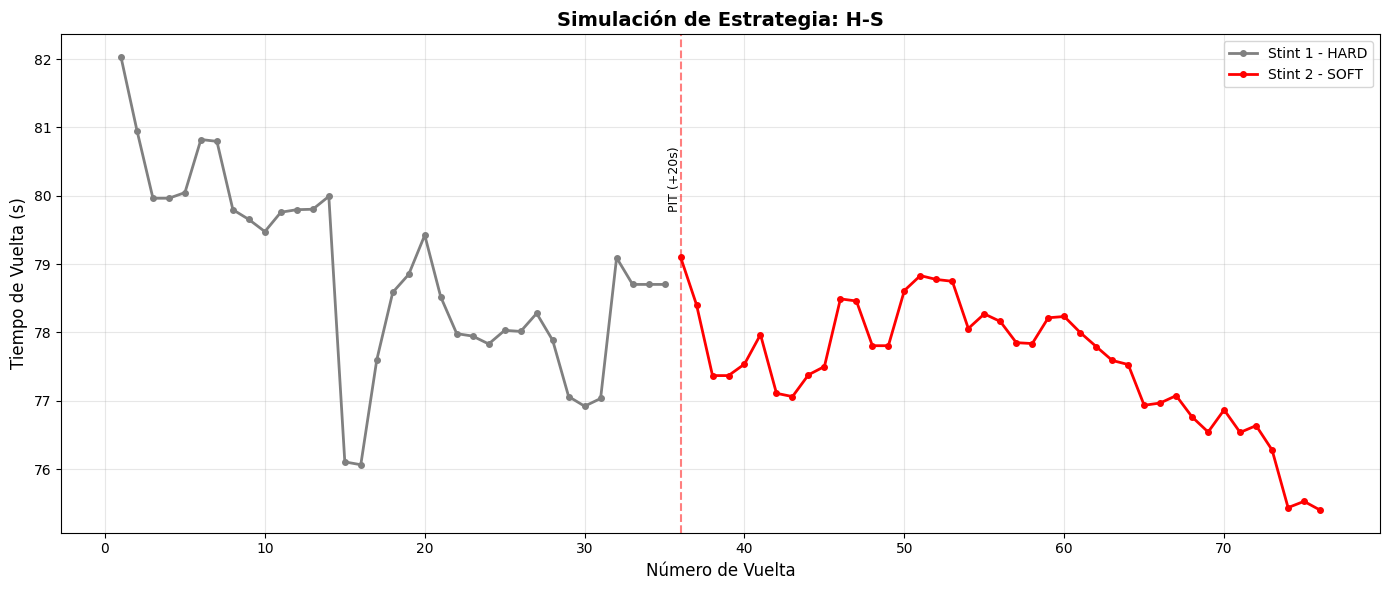


=== Resumen por Stint ===
Stint 1 (HARD): 35 vueltas - Promedio: 78.862s
Stint 2 (SOFT): 41 vueltas - Promedio: 77.532s

=== Resumen por Stint ===
Stint 1 (HARD): 35 vueltas - Promedio: 78.862s
Stint 2 (SOFT): 41 vueltas - Promedio: 77.532s


In [100]:
from src.plots import plot_strategy_lap_times, COMPOUND_COLORS

# Plot de tiempos predichos por vuelta con stints y pit stops
plot_strategy_lap_times(
    df_sim=df_best,
    strategy_name=best_strategy_name,
    compound_colors=COMPOUND_COLORS,
    title_suffix=""
)

# Resumen de tiempos por stint
print("\n=== Resumen por Stint ===")
for stint in df_best["Stint"].unique():
    stint_data = df_best[df_best["Stint"] == stint]
    compound = stint_data.iloc[0]["Compound"]
    avg_time = stint_data["LapTime_pred_s"].mean()
    n_laps = len(stint_data)
    
    print(f"Stint {stint} ({compound}): {n_laps} vueltas - Promedio: {avg_time:.3f}s")

### Comparación entre todas las estrategias

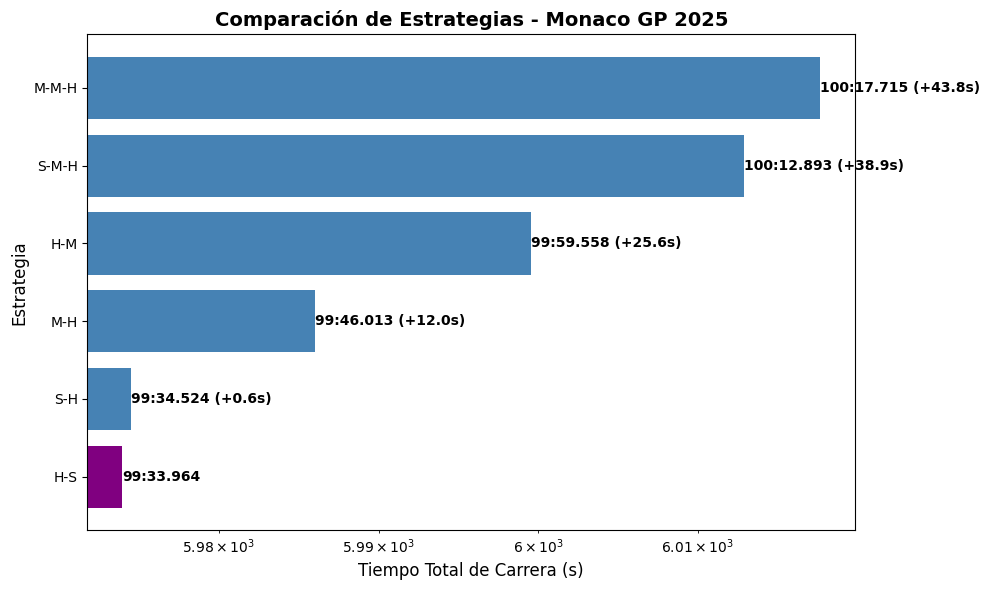

In [101]:
from src.plots import plot_strategy_comparison

# Gráfico de comparación de estrategias
plot_strategy_comparison(
    standings=standings,
    title="Comparación de Estrategias - Monaco GP 2025"
)

### Comparación con estrategia real de Colapinto

In [102]:
from src.simulator import extract_real_strategy_from_data

# Extraer la estrategia real usada por Colapinto en la carrera
df_race_real = pd.read_csv("data/processed/monaco_2025_colapinto_race.csv")

# Obtener estrategia real desde los datos
real_strategy = extract_real_strategy_from_data(df_race_real)

print("=== Estrategia Real de Colapinto ===")
print(f"Estrategia: {real_strategy.name}")
for i, (compound, laps) in enumerate(real_strategy.stints, 1):
    print(f"  Stint {i}: {compound} - {laps} vueltas")

# Simular la estrategia real
real_result = simulate_strategy_for_driver(
    df_race_base=df_race_fe,
    lap_time_model=lap_time_model,
    legal_features_num=LEGAL_FEATURES_NUM_V2,
    legal_features_cat=LEGAL_FEATURES_CAT_V2,
    strategy=real_strategy,
    pit_loss_s=20.0,
)

print(f"\nTiempo simulado con estrategia real: {real_result['total_time_s']:.3f}s")

# Comparar con la mejor estrategia
best_time_s = standings.iloc[0]['total_time_s']
time_diff = real_result['total_time_s'] - best_time_s
print(f"Mejor estrategia: {standings.iloc[0]['strategy_name']} - {best_time_s:.3f}s")
print(f"Diferencia con mejor estrategia: {'+' if time_diff > 0 else ''}{time_diff:.3f}s")
print(f"Mejora potencial: {abs(time_diff):.3f}s")

=== Estrategia Real de Colapinto ===
Estrategia: H-M-M
  Stint 1: HARD - 13 vueltas
  Stint 2: MEDIUM - 13 vueltas
  Stint 3: MEDIUM - 50 vueltas

Tiempo simulado con estrategia real: 6014.391s
Mejor estrategia: H-S - 5973.964s
Diferencia con mejor estrategia: +40.427s
Mejora potencial: 40.427s


### Clasificación completa del GP - Monaco 2025

In [103]:
from src.preprocessing import create_leaderboard_from_session

# Crear leaderboard desde la sesión de FastF1
leaderboard = create_leaderboard_from_session(session)

# Obtener información del ganador
winner = leaderboard[leaderboard["Position"] == 1].iloc[0]
winner_time_s = winner["Time_s"]

print(f"=== Ganador de la Carrera ===")
print(f"Piloto: {winner['Driver']}")
print(f"Tiempo total: {winner['Time']}")

# Obtener posición y tiempo real de Colapinto
colapinto_real = leaderboard[leaderboard["Driver"] == "COL"].iloc[0]
colapinto_position = int(colapinto_real["Position"])
colapinto_time_s = colapinto_real["Time_s"]
colapinto_gap_s = colapinto_real["Gap_s"]

print(f"\n=== Posición Real de Colapinto ===")
print(f"Posición: P{colapinto_position}")
print(f"Gap con ganador: {colapinto_real['Time']}")
print(f"Tiempo absoluto estimado: {colapinto_time_s:.3f}s")
print(f"Estado: {colapinto_real['Status']}")

# Calcular tiempo con mejor estrategia
best_time_s = standings.iloc[0]['total_time_s']

print(f"\nVueltas de carrera para simulación: {len(df_race_fe)}")
print(f"Última vuelta de carrera: {df_race_fe['LapNumber'].max()}")

=== Ganador de la Carrera ===
Piloto: NOR
Tiempo total: 0 days 01:40:33.843000

=== Posición Real de Colapinto ===
Posición: P13
Gap con ganador: 0 days 00:00:57.114000
Tiempo absoluto estimado: 6090.957s
Estado: Lapped

Vueltas de carrera para simulación: 76
Última vuelta de carrera: 76.0


In [104]:
from src.preprocessing import add_simulated_driver_to_leaderboard

# Calcular tiempo con mejor estrategia
time_saved = real_result['total_time_s'] - best_time_s

print(f"\n=== Análisis de Colapinto - Estado: Lapped ===")
print(f"Vueltas completadas: 76 (perdió 2 vueltas)")
print(f"Tiempo simulado con estrategia real (76v): {real_result['total_time_s']:.3f}s")
print(f"Tiempo simulado con mejor estrategia (76v): {best_time_s:.3f}s")
print(f"Tiempo que habría ahorrado: {time_saved:.3f}s")

# Agregar piloto simulado al leaderboard y recalcular posiciones
result = add_simulated_driver_to_leaderboard(
    leaderboard=leaderboard,
    session=session,
    driver_abbr="COL",
    simulated_time_s=best_time_s,
    simulated_laps=76,
    suffix="*"
)

leaderboard_comparison = result["leaderboard_comparison"]
leaderboard_display = result["leaderboard_display"]
position_gain = result["position_gain"]
time_saved = result["time_saved"]
colapinto_real_pos = result["driver_real_pos"]
colapinto_sim_pos = result["driver_sim_pos"]

# Mostrar tabla comparativa
print("\n=== CLASIFICACIÓN FINAL - MONACO GP 2025 ===")
print("(COL* = Colapinto con mejor estrategia simulada - mismas 76 vueltas)\n")

print(leaderboard_display.to_string(index=False))

# Resumen de cambios
print(f"\n=== RESUMEN ===")
print(f"Posición real de Colapinto: P{colapinto_real_pos} (76 vueltas)")
print(f"Posición con mejor estrategia: P{colapinto_sim_pos} (76 vueltas)")
if position_gain > 0:
    print(f"✓ Ganancia potencial: {position_gain} {'posición' if position_gain == 1 else 'posiciones'}")
    print(f"✓ Tiempo ahorrado: {time_saved:.3f}s ({time_saved/76:.3f}s por vuelta)")
elif position_gain < 0:
    print(f"✗ Pérdida: {abs(position_gain)} {'posición' if abs(position_gain) == 1 else 'posiciones'}")
else:
    print(f"Sin cambio de posición, pero {time_saved:.3f}s más rápido")


=== Análisis de Colapinto - Estado: Lapped ===
Vueltas completadas: 76 (perdió 2 vueltas)
Tiempo simulado con estrategia real (76v): 6014.391s
Tiempo simulado con mejor estrategia (76v): 5973.964s
Tiempo que habría ahorrado: 40.427s

=== CLASIFICACIÓN FINAL - MONACO GP 2025 ===
(COL* = Colapinto con mejor estrategia simulada - mismas 76 vueltas)

 Pos Driver            Team   Time/Gap   Status  Laps
   1    NOR         McLaren 100:33.843 Finished    78
   2    LEC         Ferrari +00:03.131 Finished    78
   3    PIA         McLaren +00:03.658 Finished    78
   4    VER Red Bull Racing +00:20.572 Finished    78
   5    HAM         Ferrari +00:51.387 Finished    78
   6    HAD    Racing Bulls      1 LAP   Lapped    77
   7    OCO    Haas F1 Team      1 LAP   Lapped    77
   8    LAW    Racing Bulls      1 LAP   Lapped    77
   9   COL*          Alpine     2 LAPS   Lapped    76
  10    ALB        Williams     2 LAPS   Lapped    76
  11    SAI        Williams     2 LAPS   Lapped    76
  

c:\Users\Franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


### Calcular tiempos totales reales sumando tiempos de vuelta

In [105]:
from src.preprocessing import calculate_real_race_times

# Calcular tiempos totales REALES sumando los tiempos de cada vuelta
real_race_times = calculate_real_race_times(session)

print("=== TIEMPOS TOTALES REALES (suma de tiempos de vuelta) ===\n")
print(real_race_times.sort_values(["Laps_Completed", "Total_Time_s"], ascending=[False, True]).to_string(index=False))

# Comparar con Colapinto
colapinto_data = real_race_times[real_race_times["Driver"] == "COL"].iloc[0]
colapinto_real_time = colapinto_data["Total_Time_s"]
colapinto_full_laps = colapinto_data["Laps_Completed"]

print(f"\n=== COLAPINTO - TIEMPOS REALES vs SIMULADOS ===")
print(f"Tiempo real (suma de vueltas): {colapinto_real_time:.3f}s ({colapinto_full_laps} vueltas)")
print(f"Tiempo simulado estrategia real: {real_result['total_time_s']:.3f}s (76 vueltas)")
print(f"Tiempo simulado mejor estrategia: {best_time_s:.3f}s (76 vueltas)")
print(f"\nDiferencia simulación vs realidad: {abs(real_result['total_time_s'] - colapinto_real_time):.3f}s")
print(f"Mejora potencial (simulada): {abs(real_result['total_time_s'] - best_time_s):.3f}s")

=== TIEMPOS TOTALES REALES (suma de tiempos de vuelta) ===

Driver  Total_Time_s  Laps_Completed   Status
   NOR      6033.843              78 Finished
   LEC      6036.974              78 Finished
   PIA      6037.501              78 Finished
   VER      6054.415              78 Finished
   HAM      6085.230              78 Finished
   HAD      6098.925              77   Lapped
   OCO      6099.872              77   Lapped
   LAW      6100.589              77   Lapped
   ALB      6045.712              76   Lapped
   SAI      6049.075              76   Lapped
   RUS      6067.687              76   Lapped
   BEA      6088.536              76   Lapped
   COL      6090.957              76   Lapped
   BOR      6102.267              76   Lapped
   STR      6104.238              76   Lapped
   HUL      6105.387              76   Lapped
   TSU      6105.692              76   Lapped
   ANT      6042.252              75   Lapped
   ALO      2907.102              37  Retired
   GAS       657.609

c:\Users\Franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


### Comparación visual: Óptima vs Real Simulada vs Real

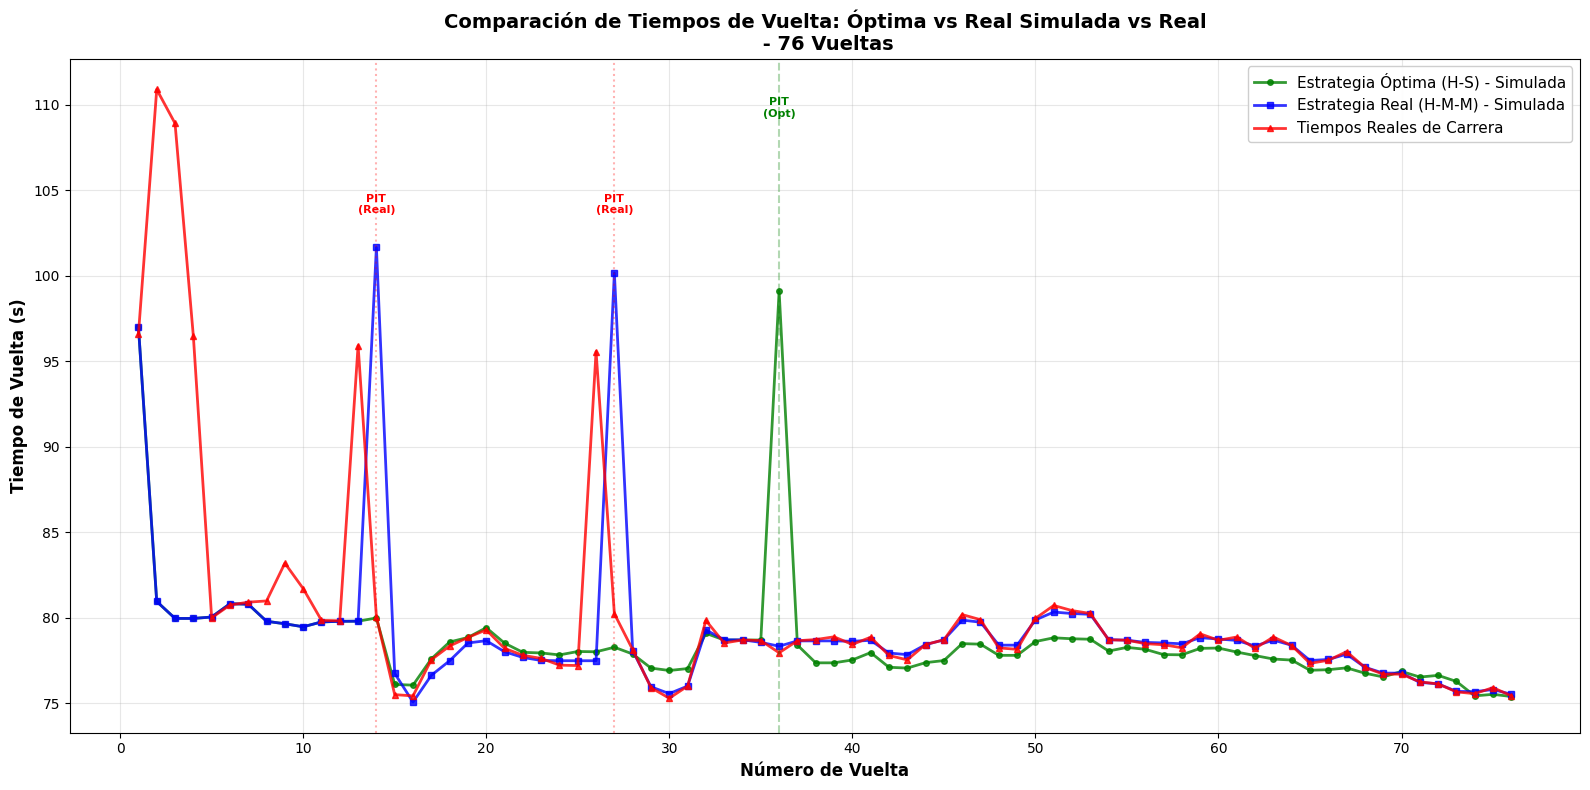


COMPARACIÓN DE ESTRATEGIAS - RESUMEN

📊 TIEMPOS TOTALES:
  • Estrategia Óptima (H-S): 99:33.964 (5973.964s)
  • Estrategia Real (H-M-M) - Simulada: 100:14.391 (6014.391s)
  • Tiempos Reales de Carrera: 101:30.957 (6090.957s)

⏱️  DIFERENCIAS DE TIEMPO:
  • Óptima vs Real simulada: +40.427s
  • Óptima vs Real actual: +116.993s
  • Real simulada vs Real actual: +76.566s

📈 TIEMPOS PROMEDIO POR VUELTA:
  • Estrategia Óptima (H-S): 78.605s
  • Estrategia Real (H-M-M) - Simulada: 79.137s
  • Tiempos Reales de Carrera: 80.144s

🎯 PRECISIÓN DEL MODELO:
  • MAE (simulación vs realidad): 2.246s por vuelta



In [106]:
from src.plots import plot_three_way_comparison
from src.metrics import calculate_comparison_statistics, print_comparison_report

# Obtener datos de las tres versiones
# 1. Estrategia óptima (H-S)
df_optimal = best_result["df_sim"].copy()
df_optimal = df_optimal.sort_values("LapNumber")

# 2. Estrategia real simulada (H-M-M)
df_real_sim = real_result["df_sim"].copy()
df_real_sim = df_real_sim.sort_values("LapNumber")

# 3. Tiempos reales de carrera
df_real_actual = pd.read_csv("data/processed/monaco_2025_colapinto_race.csv")
df_real_actual["LapTime_s"] = pd.to_timedelta(df_real_actual["LapTime"]).dt.total_seconds()
df_real_actual = df_real_actual.sort_values("LapNumber")

# Crear gráfico de comparación triple con estadísticas integradas
comparison_stats = plot_three_way_comparison(
    df_optimal=df_optimal,
    df_real_sim=df_real_sim,
    df_real_actual=df_real_actual,
    best_strategy_name=best_strategy_name,
    title_suffix=" - 76 Vueltas"
)

# Imprimir reporte de comparación detallado
print_comparison_report(
    stats=comparison_stats,
    strategy_names={
        'optimal': f'Estrategia Óptima ({best_strategy_name})',
        'real_sim': f'Estrategia Real ({real_strategy.name}) - Simulada',
        'real_actual': 'Tiempos Reales de Carrera'
    }
)

### Visualización de la clasificación con ambas estrategias

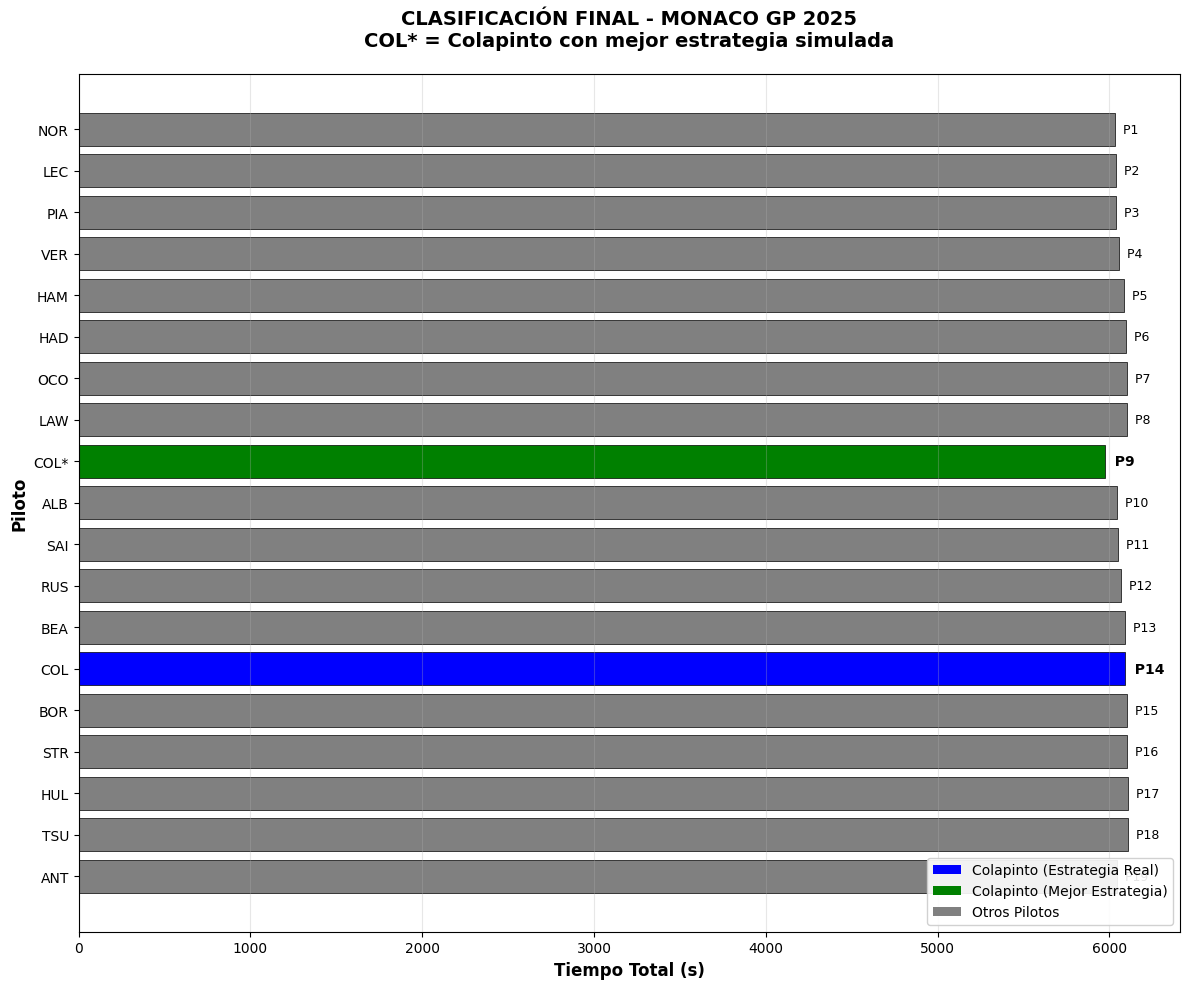

In [107]:
from src.plots import plot_leaderboard_comparison

# Visualizar clasificación final con comparación
plot_leaderboard_comparison(
    leaderboard_comparison=leaderboard_comparison,
    title="CLASIFICACIÓN FINAL - MONACO GP 2025",
    subtitle="COL* = Colapinto con mejor estrategia simulada"
)